# Part 2: Fine-tune GPT-2 with Emotion Conditioning

This notebook implements **four conditioning methods** for emotion-controlled text generation:

- **Method A (Baseline):** Plain GPT-2 without explicit emotion conditioning
- **Method B (Prefix):** Text prefix conditioning (e.g., "happy: ...")
- **Method C (Token):** Special emotion tokens (e.g., `<HAPPY>`)
- **Method D (LoRA):** Parameter-efficient fine-tuning with LoRA + special tokens

## References
- Hu et al. (2021). LoRA: Low-Rank Adaptation of Large Language Models. https://arxiv.org/abs/2106.09685
- Singh et al. (2020). Controlled Affective Text Generation. https://arxiv.org/abs/2011.04000
- Resendiz & Klinger (2023). Emotion-Conditioned Text Generation. https://aclanthology.org/2023.tllm-1.3/

In [1]:


import os
import sys
import torch
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model, TaskType
import matplotlib.pyplot as plt

# Add project root to path
sys.path.append('..')
from utils.emotion_mapping import EMOTION_TOKENS, TARGET_EMOTIONS
from utils.dailydialog_processor import load_and_prepare_dailydialog, get_emotion_distribution

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU
PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU


## 1. Load and Prepare DailyDialog Dataset

We'll prepare the dataset for all four methods.

In [2]:
# First, let's check the actual structure of DailyDialog dataset
from datasets import load_dataset

print("Loading DailyDialog to inspect structure...")
dd_dataset = load_dataset("roskoN/dailydialog")

print(f"\nDataset splits: {dd_dataset.keys()}")
print(f"\nFirst sample from train:")
sample = dd_dataset['train'][0]
print(f"Available fields: {sample.keys()}")
print(f"\nSample content:")
for key, value in sample.items():
    print(f"  {key}: {value if len(str(value)) < 200 else str(value)[:200] + '...'}")

Loading DailyDialog to inspect structure...

Dataset splits: dict_keys(['train', 'validation', 'test'])

First sample from train:
Available fields: dict_keys(['id', 'acts', 'emotions', 'utterances'])

Sample content:
  id: a438b751ab9997cdb35f07bfe3dfb010b96365f4762d77f87e5f41290ff61c3d_0
  acts: [3, 4, 2, 2, 2, 3, 4, 1, 3, 4]
  emotions: [0, 0, 0, 0, 0, 0, 4, 4, 4, 4]
  utterances: ['Say , Jim , how about going for a few beers after dinner ?', 'You know that is tempting but is really not good for our fitness .', 'What do you mean ? It will help us to relax .', "Do you really thi...

Dataset splits: dict_keys(['train', 'validation', 'test'])

First sample from train:
Available fields: dict_keys(['id', 'acts', 'emotions', 'utterances'])

Sample content:
  id: a438b751ab9997cdb35f07bfe3dfb010b96365f4762d77f87e5f41290ff61c3d_0
  acts: [3, 4, 2, 2, 2, 3, 4, 1, 3, 4]
  emotions: [0, 0, 0, 0, 0, 0, 4, 4, 4, 4]
  utterances: ['Say , Jim , how about going for a few beers after dinner ?', 'You 

In [ ]:
# Configuration
METHODS = ['baseline', 'prefix', 'token', 'lora']
MODEL_NAME = 'microsoft/DialoGPT-small'  # Better dialogue-pretrained model
USE_CONTEXT = True  # Use previous utterance as context

print("Loading DailyDialog dataset for all methods...\n")

# Load data for each method
datasets = {}
for method in METHODS:
    print(f"\n{'='*60}")
    print(f"Preparing data for: {method.upper()}")
    print('='*60)
    
    data = load_and_prepare_dailydialog(
        method=method if method != 'lora' else 'token',  # LoRA uses same format as token
        use_context=USE_CONTEXT
    )
    datasets[method] = data
    
    # Show emotion distribution
    dist = get_emotion_distribution(data['train'])
    print(f"\nEmotion distribution:")
    for emotion, count in sorted(dist.items(), key=lambda x: x[1], reverse=True)[:3]:
        print(f"  {emotion}: {count} ({count/len(data['train'])*100:.1f}%)")

print("\n✅ All datasets prepared successfully!")

Loading DailyDialog dataset for all methods...


Preparing data for: BASELINE
Loading DailyDialog dataset...
Extracting context-response pairs...
Extracting context-response pairs...
Train samples: 76052
Validation samples: 7069
Test samples: 6740
Preparing data for method: baseline

=== Sample from baseline dataset ===
Say , Jim , how about going for a few beers after dinner ?
You know that is tempting but is really not good for our fitness .
Emotion: neutral

Emotion distribution:
  neutral: 62357 (82.0%)
  happy: 10253 (13.5%)
  surprise: 1504 (2.0%)

Preparing data for: PREFIX
Loading DailyDialog dataset...
Train samples: 76052
Validation samples: 7069
Test samples: 6740
Preparing data for method: baseline

=== Sample from baseline dataset ===
Say , Jim , how about going for a few beers after dinner ?
You know that is tempting but is really not good for our fitness .
Emotion: neutral

Emotion distribution:
  neutral: 62357 (82.0%)
  happy: 10253 (13.5%)
  surprise: 1504 (2.0%)

Pre

## 2. Modular Training Function

This function handles training for all four methods with appropriate configurations.

In [ ]:
def prepare_tokenizer(method, base_model_name='microsoft/DialoGPT-small'):
    """
    Prepare tokenizer with special tokens if needed.
    
    Args:
        method (str): Training method
        base_model_name (str): Base model name
        
    Returns:
        AutoTokenizer: Configured tokenizer
    """
    tokenizer = AutoTokenizer.from_pretrained(base_model_name)
    
    # Set pad token
    tokenizer.pad_token = tokenizer.eos_token
    
    # Add special emotion tokens for token and LoRA methods
    if method in ['token', 'lora']:
        num_added = tokenizer.add_special_tokens({'additional_special_tokens': EMOTION_TOKENS})
        print(f"  Added {num_added} emotion tokens: {EMOTION_TOKENS}")
    
    return tokenizer


def prepare_model(method, tokenizer, base_model_name='microsoft/DialoGPT-small'):
    """
    Prepare model with LoRA if needed.
    
    Args:
        method (str): Training method
        tokenizer: Tokenizer (for resizing embeddings)
        base_model_name (str): Base model name
        
    Returns:
        Model: Configured model
    """
    model = AutoModelForCausalLM.from_pretrained(base_model_name)
    
    # Resize embeddings if tokens were added
    if method in ['token', 'lora']:
        model.resize_token_embeddings(len(tokenizer))
        print(f"  Resized embeddings to {len(tokenizer)} tokens")
    
    # Apply LoRA for method D
    if method == 'lora':
        print("  Applying LoRA configuration...")
        lora_config = LoraConfig(
            task_type=TaskType.CAUSAL_LM,
            r=8,  # Rank
            lora_alpha=16,  # Alpha
            lora_dropout=0.05,
            target_modules=['c_attn', 'c_proj'],  # GPT-2 attention modules
            bias="none"
        )
        model = get_peft_model(model, lora_config)
        model.print_trainable_parameters()
    
    return model


def tokenize_dataset(data, tokenizer, max_length=256):
    """
    Tokenize dataset for language modeling.
    
    Args:
        data (list): List of samples with 'text' field
        tokenizer: Tokenizer
        max_length (int): Maximum sequence length
        
    Returns:
        Dataset: Tokenized dataset
    """
    texts = [sample['text'] for sample in data]
    
    # Tokenize
    encodings = tokenizer(
        texts,
        truncation=True,
        max_length=max_length,
        padding=False  # Dynamic padding in collator
    )
    
    # Create dataset
    dataset = Dataset.from_dict({
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask']
    })
    
    return dataset


def train_gpt2_variant(
    method,
    train_data,
    val_data,
    base_model_name='microsoft/DialoGPT-small',
    num_epochs=5,
    batch_size=8,
    learning_rate=2e-5,
    max_length=256,
    output_dir=None
):
    """
    Train GPT-2 variant with specified conditioning method.
    
    Args:
        method (str): Training method ('baseline', 'prefix', 'token', 'lora')
        train_data (list): Training data
        val_data (list): Validation data
        base_model_name (str): Base model name
        num_epochs (int): Number of training epochs
        batch_size (int): Training batch size
        learning_rate (float): Learning rate
        max_length (int): Maximum sequence length
        output_dir (str): Output directory for model
        
    Returns:
        tuple: (trainer, tokenizer, model)
    """
    print(f"\n{'='*70}")
    print(f"Training Method: {method.upper()}")
    print('='*70)
    
    # Prepare tokenizer and model
    print("\n1. Preparing tokenizer...")
    tokenizer = prepare_tokenizer(method, base_model_name)
    
    print("\n2. Preparing model...")
    model = prepare_model(method, tokenizer, base_model_name)
    
    # Tokenize datasets
    print("\n3. Tokenizing datasets...")
    train_dataset = tokenize_dataset(train_data, tokenizer, max_length)
    val_dataset = tokenize_dataset(val_data, tokenizer, max_length)
    print(f"  Train samples: {len(train_dataset)}")
    print(f"  Validation samples: {len(val_dataset)}")
    
    # Data collator for language modeling
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False  # Causal LM, not masked LM
    )
    
    # Training arguments
    if output_dir is None:
        output_dir = f"../models/gpt2_{method}"
    
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=learning_rate,
        warmup_steps=1000,
        weight_decay=0.01,
        logging_dir=f"{output_dir}/logs",
        logging_steps=500,
        evaluation_strategy="epoch",  # FIXED: Changed from "steps" to "epoch" to match save_strategy
        save_strategy="epoch",
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        push_to_hub=False,
        report_to="none",
        seed=42,
        fp16=torch.cuda.is_available()  # Use mixed precision if GPU available
    )
    
    print("\n4. Training configuration:")
    print(f"  Epochs: {num_epochs}")
    print(f"  Batch size: {batch_size}")
    print(f"  Learning rate: {learning_rate}")
    print(f"  Max length: {max_length}")
    print(f"  Output: {output_dir}")
    print(f"  FP16: {training_args.fp16}")
    
    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=data_collator,
        tokenizer=tokenizer
    )
    
    print("\n5. Starting training...")
    print("="*70)
    
    # Train
    train_result = trainer.train()
    
    print("\n" + "="*70)
    print("Training complete!")
    print("="*70)
    
    # Display training metrics
    print("\n=== Training Metrics ===")
    for key, value in train_result.metrics.items():
        print(f"{key}: {value:.4f}")
    
    # Save model and tokenizer
    print(f"\n6. Saving model to {output_dir}...")
    trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)
    
    # For LoRA, also save the base model configuration
    if method == 'lora':
        model.save_pretrained(output_dir)
    
    print("\n✅ Model saved successfully!\n")
    
    return trainer, tokenizer, model


print("Training functions defined successfully!")

Training functions defined successfully!


## 3. Train Method A: Baseline

Plain GPT-2 without explicit emotion conditioning.

In [5]:
# Train baseline model
trainer_baseline, tokenizer_baseline, model_baseline = train_gpt2_variant(
    method='baseline',
    train_data=datasets['baseline']['train'],
    val_data=datasets['baseline']['validation'],
    num_epochs=2,
    batch_size=8,
    learning_rate=5e-5
)


Training Method: BASELINE

1. Preparing tokenizer...

2. Preparing model...

2. Preparing model...

3. Tokenizing datasets...

3. Tokenizing datasets...
  Train samples: 76052
  Validation samples: 7069

4. Training configuration:
  Epochs: 2
  Batch size: 8
  Learning rate: 5e-05
  Max length: 256
  Output: ../models/gpt2_baseline
  FP16: True
  Train samples: 76052
  Validation samples: 7069

4. Training configuration:
  Epochs: 2
  Batch size: 8
  Learning rate: 5e-05
  Max length: 256
  Output: ../models/gpt2_baseline
  FP16: True


d:\LLM_Chatbot\llmvenv\lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\Asus\AppData\Local\Temp\ipykernel_140100\658104220.py:179: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



5. Starting training...


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,2.626200,2.713268
2,2.388200,2.677005


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].



Training complete!

=== Training Metrics ===
train_runtime: 2003.1452
train_samples_per_second: 75.9330
train_steps_per_second: 9.4920
total_flos: 4617287414784000.0000
train_loss: 2.6045
epoch: 2.0000

6. Saving model to ../models/gpt2_baseline...

✅ Model saved successfully!


✅ Model saved successfully!



## 4. Train Method B: Prefix Conditioning

Text prefix conditioning (e.g., "happy: response").

In [ ]:
# Train prefix model with improved settings
trainer_prefix, tokenizer_prefix, model_prefix = train_gpt2_variant(
    method='prefix',
    train_data=datasets['prefix']['train'],
    val_data=datasets['prefix']['validation'],
    num_epochs=5,
    batch_size=8,
    learning_rate=2e-5
)


Training Method: PREFIX

1. Preparing tokenizer...

2. Preparing model...

2. Preparing model...

3. Tokenizing datasets...

3. Tokenizing datasets...
  Train samples: 76052
  Validation samples: 7069

4. Training configuration:
  Epochs: 2
  Batch size: 8
  Learning rate: 5e-05
  Max length: 256
  Output: ../models/gpt2_prefix
  FP16: True
  Train samples: 76052
  Validation samples: 7069

4. Training configuration:
  Epochs: 2
  Batch size: 8
  Learning rate: 5e-05
  Max length: 256
  Output: ../models/gpt2_prefix
  FP16: True


d:\LLM_Chatbot\llmvenv\lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\Asus\AppData\Local\Temp\ipykernel_140100\658104220.py:179: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



5. Starting training...


Epoch,Training Loss,Validation Loss
1,2.466400,2.534934
2,2.251400,2.499738


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].



Training complete!

=== Training Metrics ===
train_runtime: 7111.7001
train_samples_per_second: 21.3880
train_steps_per_second: 2.6740
total_flos: 4775332349952000.0000
train_loss: 2.4547
epoch: 2.0000

6. Saving model to ../models/gpt2_prefix...

✅ Model saved successfully!


✅ Model saved successfully!



## 5. Train Method C: Special Token Conditioning

Special emotion tokens (e.g., `<HAPPY>`).

In [ ]:
# Train token model with improved settings
trainer_token, tokenizer_token, model_token = train_gpt2_variant(
    method='token',
    train_data=datasets['token']['train'],
    val_data=datasets['token']['validation'],
    num_epochs=5,
    batch_size=8,
    learning_rate=2e-5
)


Training Method: TOKEN

1. Preparing tokenizer...
  Added 7 emotion tokens: ['<NEUTRAL>', '<HAPPY>', '<SAD>', '<ANGRY>', '<FEAR>', '<DISGUST>', '<SURPRISE>']

2. Preparing model...
  Added 7 emotion tokens: ['<NEUTRAL>', '<HAPPY>', '<SAD>', '<ANGRY>', '<FEAR>', '<DISGUST>', '<SURPRISE>']

2. Preparing model...


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


  Resized embeddings to 50264 tokens

3. Tokenizing datasets...
  Train samples: 76052
  Validation samples: 7069

4. Training configuration:
  Epochs: 2
  Batch size: 8
  Learning rate: 5e-05
  Max length: 256
  Output: ../models/gpt2_token
  FP16: True
  Train samples: 76052
  Validation samples: 7069

4. Training configuration:
  Epochs: 2
  Batch size: 8
  Learning rate: 5e-05
  Max length: 256
  Output: ../models/gpt2_token
  FP16: True


d:\LLM_Chatbot\llmvenv\lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\Asus\AppData\Local\Temp\ipykernel_140100\658104220.py:179: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



5. Starting training...


Epoch,Training Loss,Validation Loss
1,2.653700,2.763767
2,2.429500,2.729556


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].



Training complete!

=== Training Metrics ===
train_runtime: 3148.6444
train_samples_per_second: 48.3080
train_steps_per_second: 6.0390
total_flos: 4693380553728000.0000
train_loss: 2.6360
epoch: 2.0000

6. Saving model to ../models/gpt2_token...

✅ Model saved successfully!


✅ Model saved successfully!



## 6. Train Method D: LoRA with Token Conditioning

Parameter-efficient fine-tuning with LoRA (Rank=8, Alpha=16, Dropout=0.05).

In [8]:
# Train LoRA model
trainer_lora, tokenizer_lora, model_lora = train_gpt2_variant(
    method='lora',
    train_data=datasets['lora']['train'],
    val_data=datasets['lora']['validation'],
    num_epochs=2,
    batch_size=8,
    learning_rate=1e-4  # Higher LR for LoRA
)


Training Method: LORA

1. Preparing tokenizer...
  Added 7 emotion tokens: ['<NEUTRAL>', '<HAPPY>', '<SAD>', '<ANGRY>', '<FEAR>', '<DISGUST>', '<SURPRISE>']

2. Preparing model...
  Added 7 emotion tokens: ['<NEUTRAL>', '<HAPPY>', '<SAD>', '<ANGRY>', '<FEAR>', '<DISGUST>', '<SURPRISE>']

2. Preparing model...
  Resized embeddings to 50264 tokens
  Applying LoRA configuration...
trainable params: 811,008 || all params: 125,256,192 || trainable%: 0.6475

3. Tokenizing datasets...
  Resized embeddings to 50264 tokens
  Applying LoRA configuration...
trainable params: 811,008 || all params: 125,256,192 || trainable%: 0.6475

3. Tokenizing datasets...


d:\LLM_Chatbot\llmvenv\lib\site-packages\peft\tuners\lora\layer.py:2174: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


  Train samples: 76052
  Validation samples: 7069

4. Training configuration:
  Epochs: 2
  Batch size: 8
  Learning rate: 0.0001
  Max length: 256
  Output: ../models/gpt2_lora
  FP16: True


d:\LLM_Chatbot\llmvenv\lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\Asus\AppData\Local\Temp\ipykernel_140100\658104220.py:179: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



5. Starting training...


Epoch,Training Loss,Validation Loss
1,2.994300,2.993249
2,2.962400,2.971061


d:\LLM_Chatbot\llmvenv\lib\site-packages\peft\utils\save_and_load.py:300: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
d:\LLM_Chatbot\llmvenv\lib\site-packages\peft\utils\save_and_load.py:300: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
d:\LLM_Chatbot\llmvenv\lib\site-packages\peft\utils\save_and_load.py:300: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
d:\LLM_Chatbot\llmvenv\lib\site-packages\peft\utils\save_and_load.py:300: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
d:\LLM_Chatbot\llmvenv\lib\site-packages\peft\utils\save_and_load.py:300: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during fine


Training complete!

=== Training Metrics ===
train_runtime: 1208.4744
train_samples_per_second: 125.8640
train_steps_per_second: 15.7340
total_flos: 4738131884335104.0000
train_loss: 3.0214
epoch: 2.0000

6. Saving model to ../models/gpt2_lora...


d:\LLM_Chatbot\llmvenv\lib\site-packages\peft\utils\save_and_load.py:300: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(



✅ Model saved successfully!



## 7. Compare Training Losses

In [9]:
# Extract training losses from all models
trainers = {
    'Baseline': trainer_baseline,
    'Prefix': trainer_prefix,
    'Token': trainer_token,
    'LoRA': trainer_lora
}

# Evaluate all models on validation set
print("\n=== Final Validation Loss Comparison ===")
results_summary = []

for name, trainer in trainers.items():
    # Get validation loss
    eval_results = trainer.evaluate()
    val_loss = eval_results['eval_loss']
    
    results_summary.append({
        'Method': name,
        'Validation Loss': val_loss
    })
    
    print(f"{name:12s} - Validation Loss: {val_loss:.4f}")

# Create summary DataFrame
df_results = pd.DataFrame(results_summary)
print("\n", df_results.to_string(index=False))


=== Final Validation Loss Comparison ===


Baseline     - Validation Loss: 2.6770


Prefix       - Validation Loss: 2.4997


Token        - Validation Loss: 2.7296


LoRA         - Validation Loss: 2.9711

   Method  Validation Loss
Baseline         2.677005
  Prefix         2.499738
   Token         2.729556
    LoRA         2.971061


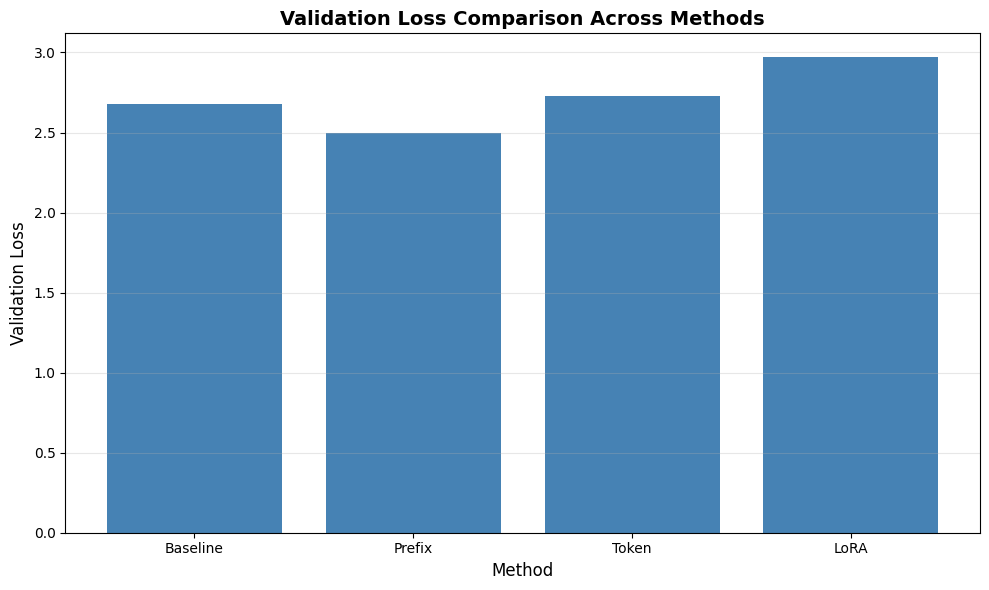

In [10]:
# Visualize comparison
plt.figure(figsize=(10, 6))
plt.bar(df_results['Method'], df_results['Validation Loss'], color='steelblue')
plt.title('Validation Loss Comparison Across Methods', fontsize=14, fontweight='bold')
plt.xlabel('Method', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../results/training_loss_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Test Generation from Each Model

In [11]:
# Test generation with a sample context
from utils.text_generation import EmotionControlledGenerator

test_context = "How was your day?"
test_emotion = "happy"

print(f"\n{'='*70}")
print(f"Test Generation: '{test_context}'")
print(f"Target Emotion: {test_emotion.upper()}")
print('='*70)

models_to_test = [
    ('Baseline', '../models/gpt2_baseline', 'baseline'),
    ('Prefix', '../models/gpt2_prefix', 'prefix'),
    ('Token', '../models/gpt2_tokens', 'token'),
    ('LoRA', '../models/gpt2_lora', 'lora')
]

for name, model_path, method in models_to_test:
    print(f"\n[{name}]")
    try:
        generator = EmotionControlledGenerator(model_path, conditioning_method=method)
        response = generator.generate_response(
            context=test_context,
            target_emotion=test_emotion,
            max_length=80,
            temperature=0.7,
            num_return_sequences=1
        )[0]
        print(f"Response: {response}")
    except Exception as e:
        print(f"Error: {e}")


Test Generation: 'How was your day?'
Target Emotion: HAPPY

[Baseline]
Loading model from: ../models/gpt2_baseline
Conditioning method: baseline
Using device: cuda
Model loaded successfully
Model loaded successfully
Response: I was really lucky , actually . I went out to dinner with my friends . It was really a great meal . We had a great time . I was also very lucky because I didn ’ t have to buy any food . I had enough money to buy a new refrigerator and freezer . It was a really great investment . I ’ Ve learned a lot from it

[Prefix]
Loading model from: ../models/gpt2_prefix
Conditioning method: prefix
Using device: cuda
Response: I was really lucky , actually . I went out to dinner with my friends . It was really a great meal . We had a great time . I was also very lucky because I didn ’ t have to buy any food . I had enough money to buy a new refrigerator and freezer . It was a really great investment . I ’ Ve learned a lot from it

[Prefix]
Loading model from: ../models/gpt2_p

## Summary

✅ Successfully trained 4 GPT-2 variants:
- **Baseline:** Plain GPT-2
- **Prefix:** Text prefix conditioning
- **Token:** Special emotion tokens
- **LoRA:** Parameter-efficient with LoRA (Rank=8, Alpha=16, Dropout=0.05)

✅ All models saved and ready for evaluation

**Next Steps:**
- Proceed to Notebook 03 for comprehensive evaluation
- Measure BLEU, ROUGE, perplexity, and emotion accuracy
- Compare effectiveness of conditioning methods